In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create dataloaders for training
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

# Define paths to stored pickle files
DATASET_PATH = "/content/drive/My Drive/Chord_Pandas_Dataset/"
train_pkl = os.path.join(DATASET_PATH, "train.pkl")
val_pkl = os.path.join(DATASET_PATH, "val.pkl")
test_pkl = os.path.join(DATASET_PATH, "test.pkl")

# Load datasets from pickle files
df_train = pd.read_pickle(train_pkl)
df_val = pd.read_pickle(val_pkl)
df_test = pd.read_pickle(test_pkl)

# Encode labels into integers
label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["label"])
df_val["label"] = label_encoder.transform(df_val["label"])
df_test["label"] = label_encoder.transform(df_test["label"])

class AudioDataset(Dataset):
    def __init__(self, df):
        # Extract PCP vectors and convert to NumPy array
        pcp_vectors = [x[0] for x in df["pcp"]]  # Access the first element (PCP vector) of each tuple
        self.features = torch.tensor(np.vstack(pcp_vectors), dtype=torch.float32)
        self.labels = torch.tensor(df["label"].values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders with hyperparameter batch size
train_dataset = AudioDataset(df_train)
val_dataset = AudioDataset(df_val)
test_dataset = AudioDataset(df_test)




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

class convModel(nn.Module):
  def __init__(self):
    super(convModel, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    self.dropout = nn.Dropout(0.2)

    self.fc1 = nn.Linear(64*12, 64)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, 4)


  def forward(self, x):
    x = x.unsqueeze(1)  # Reshape from (batch_size, 12) to (batch_size, 1, 12)
    x = F.relu(self.conv1(x))
    x = self.dropout(x)

    x = F.relu(self.conv2(x))
    x = self.dropout(x)

    x = F.relu(self.conv3(x))

    x = x.view(x.size(0), -1)  # Flatten the tensor
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
import time

def train_model_CNN(model, train_loader, val_loader, num_epochs, criterion, optimizer):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  start_time = time.time()
  train_acc_history = np.zeros(num_epochs)  # Initialize empty list for train acc
  val_acc_history = np.zeros(num_epochs)
  train_loss_history = np.zeros(num_epochs)
  val_loss_history = np.zeros(num_epochs)

  print("Starting Training")
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(features)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss_history[epoch] = train_loss/ len(train_loader)
    train_acc_history[epoch] = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
      for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss_history[epoch] = val_loss / len(val_loader)
    val_acc_history[epoch] = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_history[epoch]:.4f}, Train Acc: {train_acc_history[epoch]:.4f}, || Val Loss: {val_loss_history[epoch]:.4f}, Val Acc: {val_acc_history[epoch]:.4f}")

  print("Finished Training")
  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  #save training files
  path = "/content/drive/My Drive/Chord_Model/1DCNN/"
  np.savetxt("{}train_acc.csv".format(path), train_acc_history)
  np.savetxt("{}val_acc.csv".format(path), val_acc_history)
  np.savetxt("{}train_loss.csv".format(path), train_loss_history)
  np.savetxt("{}val_loss.csv".format(path), val_loss_history)


In [ ]:
prim_model = convModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(prim_model.parameters(), lr=0.01)
num_epochs = 40

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prim_model.to(device)

train_model_CNN(prim_model, train_loader, val_loader, num_epochs, criterion, optimizer)


Starting Training
Epoch 1/40, Train Loss: 1.1468, Train Acc: 0.4340, || Val Loss: 0.6933, Val Acc: 0.7092
Epoch 2/40, Train Loss: 0.6705, Train Acc: 0.7022, || Val Loss: 0.4549, Val Acc: 0.7958
Epoch 3/40, Train Loss: 0.5378, Train Acc: 0.7598, || Val Loss: 0.3962, Val Acc: 0.8137
Epoch 4/40, Train Loss: 0.5099, Train Acc: 0.7625, || Val Loss: 0.4160, Val Acc: 0.7958
Epoch 5/40, Train Loss: 0.4906, Train Acc: 0.7770, || Val Loss: 0.3814, Val Acc: 0.8121
Epoch 6/40, Train Loss: 0.4616, Train Acc: 0.7810, || Val Loss: 0.3794, Val Acc: 0.8170
Epoch 7/40, Train Loss: 0.4624, Train Acc: 0.7853, || Val Loss: 0.3715, Val Acc: 0.8203
Epoch 8/40, Train Loss: 0.4863, Train Acc: 0.7714, || Val Loss: 0.3378, Val Acc: 0.8284
Epoch 9/40, Train Loss: 0.4556, Train Acc: 0.7882, || Val Loss: 0.3678, Val Acc: 0.8219
Epoch 10/40, Train Loss: 0.4347, Train Acc: 0.7898, || Val Loss: 0.3597, Val Acc: 0.8219
Epoch 11/40, Train Loss: 0.4778, Train Acc: 0.7837, || Val Loss: 0.4750, Val Acc: 0.7876
Epoch 12/40,

The val acc looks higher than our previous model but it also starts off very high. lets plot the curves and see what they look like

In [ ]:
#plot train/val curve
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

def plot_curves():
  path = "/content/drive/My Drive/Chord_Model/1DCNN/"

  train_acc = np.loadtxt("{}train_acc.csv".format(path))
  val_acc = np.loadtxt("{}val_acc.csv".format(path))
  train_loss = np.loadtxt("{}train_loss.csv".format(path))
  val_loss = np.loadtxt("{}val_loss.csv".format(path))

  plt.title("Train vs Val Accuracy: CNN model")
  n = len(train_acc)
  plt.plot(range(1, n+1), train_acc, label = "Train Accuracy")
  plt.plot(range(1, n+1), val_acc, label = "Val Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.title("Train vs Val Loss: CNN model")
  plt.plot(range(1, n+1), train_loss, label = "Train Loss")
  plt.plot(range(1, n+1), val_loss, label = "Val Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


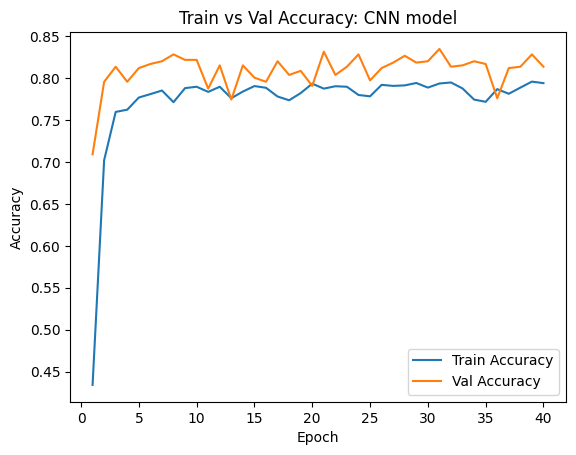

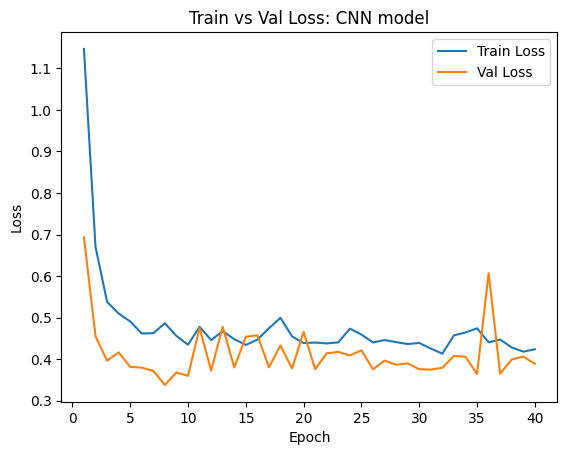

In [ ]:


plot_curves()

Tweaking hyperparams:

In [ ]:
prim_model = convModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(prim_model.parameters(), lr=0.01, momentum = 0.9)
num_epochs = 100

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prim_model.to(device)

train_model_CNN(prim_model, train_loader, val_loader, num_epochs, criterion, optimizer)


Starting Training
Epoch 1/100, Train Loss: 1.3711, Train Acc: 0.2874, || Val Loss: 1.2413, Val Acc: 0.3301
Epoch 2/100, Train Loss: 0.8990, Train Acc: 0.5917, || Val Loss: 0.5485, Val Acc: 0.7680
Epoch 3/100, Train Loss: 0.5746, Train Acc: 0.7484, || Val Loss: 0.4104, Val Acc: 0.8137
Epoch 4/100, Train Loss: 0.4820, Train Acc: 0.7786, || Val Loss: 0.4357, Val Acc: 0.8137
Epoch 5/100, Train Loss: 0.4507, Train Acc: 0.7898, || Val Loss: 0.3749, Val Acc: 0.8170
Epoch 6/100, Train Loss: 0.4396, Train Acc: 0.7955, || Val Loss: 0.3525, Val Acc: 0.8154
Epoch 7/100, Train Loss: 0.4320, Train Acc: 0.7927, || Val Loss: 0.3459, Val Acc: 0.8252
Epoch 8/100, Train Loss: 0.4215, Train Acc: 0.8013, || Val Loss: 0.3568, Val Acc: 0.8333
Epoch 9/100, Train Loss: 0.4150, Train Acc: 0.8039, || Val Loss: 0.3570, Val Acc: 0.8235
Epoch 10/100, Train Loss: 0.4048, Train Acc: 0.8033, || Val Loss: 0.3779, Val Acc: 0.8154
Epoch 11/100, Train Loss: 0.4061, Train Acc: 0.8084, || Val Loss: 0.3846, Val Acc: 0.8203
E

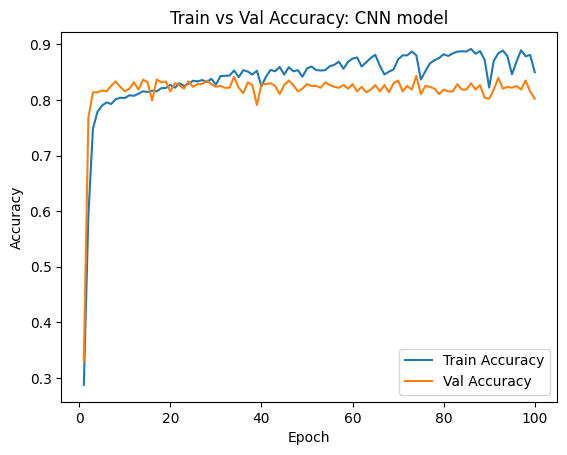

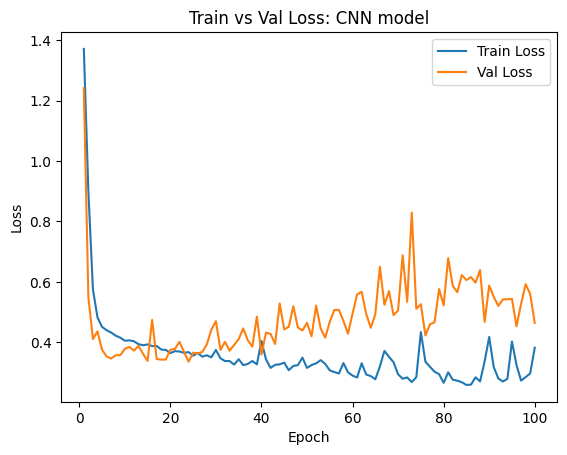

In [ ]:
plot_curves()

Looking at the training curves below, it seems the model has overfit. We will implement dropout and see if it helps. I also changed lr and momentum

In [ ]:
prim_model = convModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(prim_model.parameters(), lr=0.001, momentum = 0.99)
num_epochs = 100

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prim_model.to(device)

train_model_CNN(prim_model, train_loader, val_loader, num_epochs, criterion, optimizer)


Starting Training
Epoch 1/100, Train Loss: 1.3925, Train Acc: 0.2441, || Val Loss: 1.3891, Val Acc: 0.2533
Epoch 2/100, Train Loss: 1.3904, Train Acc: 0.2443, || Val Loss: 1.3893, Val Acc: 0.2533
Epoch 3/100, Train Loss: 1.3877, Train Acc: 0.2418, || Val Loss: 1.3867, Val Acc: 0.2516
Epoch 4/100, Train Loss: 1.3864, Train Acc: 0.2535, || Val Loss: 1.3866, Val Acc: 0.2565
Epoch 5/100, Train Loss: 1.3862, Train Acc: 0.2461, || Val Loss: 1.3845, Val Acc: 0.2680
Epoch 6/100, Train Loss: 1.3832, Train Acc: 0.2784, || Val Loss: 1.3786, Val Acc: 0.2827
Epoch 7/100, Train Loss: 1.3648, Train Acc: 0.2992, || Val Loss: 1.3227, Val Acc: 0.3464
Epoch 8/100, Train Loss: 1.2601, Train Acc: 0.3930, || Val Loss: 1.0960, Val Acc: 0.4967
Epoch 9/100, Train Loss: 1.0987, Train Acc: 0.4628, || Val Loss: 0.9778, Val Acc: 0.5114
Epoch 10/100, Train Loss: 1.0935, Train Acc: 0.4718, || Val Loss: 0.9875, Val Acc: 0.5408
Epoch 11/100, Train Loss: 1.0701, Train Acc: 0.4949, || Val Loss: 0.9453, Val Acc: 0.5605
E

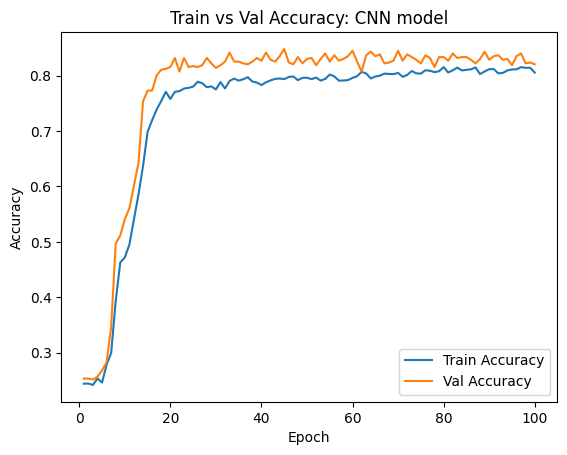

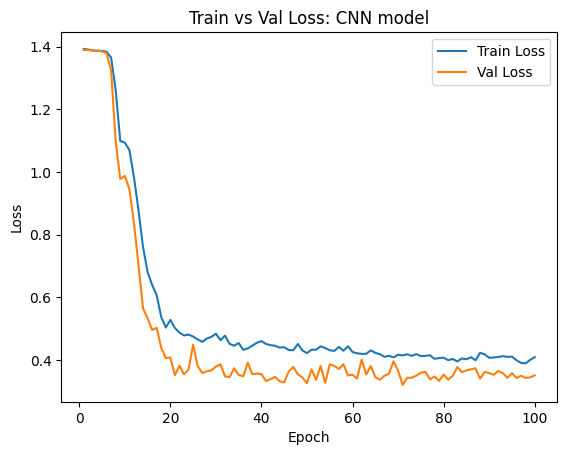

In [ ]:
plot_curves()

In [ ]:
# Confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, dataset, label_encoder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    all_preds = []
    all_labels = []

    misclassified_examples = []

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)  # Get predicted labels

            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified_examples.append((features[i], labels[i], preds[i]))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    chord_labels = list(label_encoder.classes_)

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
                xticklabels=chord_labels, yticklabels=chord_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return misclassified_examples

def test_model(model, test_loader, criterion):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()
  test_loss = 0.0
  test_correct = 0
  total = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)
          outputs = model(features)
          #calculating loss
          loss = criterion(outputs, labels)
          test_loss += loss.item() * features.size(0)
          test_correct += (outputs.argmax(dim=1) == labels).sum().item()
          total += features.size(0)

  avg_loss = test_loss / total
  accuracy = test_correct / total

  print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")



Test Loss: 0.4499, Test Accuracy: 0.7794


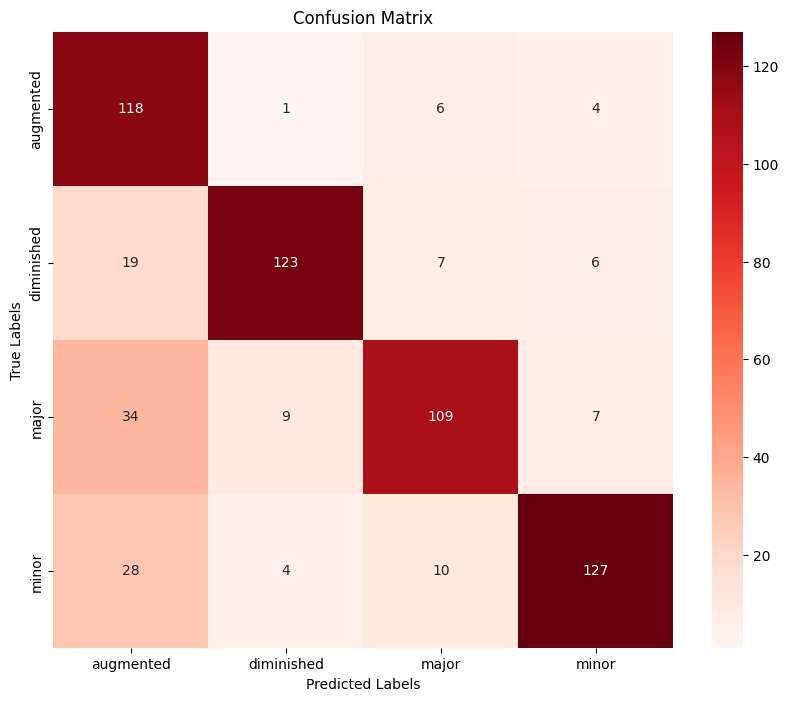

135 misclassified examples out of  612
Label: 0, Chord: augmented, length: 129
Label: 1, Chord: diminished, length: 155
Label: 2, Chord: major, length: 159
Label: 3, Chord: minor, length: 169


In [ ]:
test_model(prim_model, test_loader, criterion)
misclassified_examples_2 = plot_confusion_matrix(prim_model, test_loader, test_dataset, label_encoder) # Pass label_encoder
print(len(misclassified_examples_2), "misclassified examples out of ", len(test_dataset))

for idx, label in enumerate(label_encoder.classes_):
    print(f"Label: {idx}, Chord: {label}, length: {len(df_test[df_test['label'] == idx])}") # Access original DataFrame for length
